# Toxic Spans Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import ast
from termcolor import colored
import string
from nltk.tokenize import word_tokenize 
from tqdm import trange

sns.set_style('darkgrid')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

![title](../Images/pipeline.jpeg)

## Resumen

1. Quitando símbolos tóxicos (", espacios, !, etc) tenemos los siguientes resultados:
  - Hidden Markov Model: 0.321
  - Conditional Random Fields: 0.551
  - LSTM: 0.561 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
2. Quitando símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - Hidden Markov Model: 0.299
  - Conditional Random Fields: 0.546
  - LSTM: 0.556 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
  
3. Sin quitar símbolos tóxicos (", espacios, !, etc), es decir, dataset original:
  - Hidden Markov Model: 0.367
  - Conditional Random Fields: 0.501
  - LSTM: 0.535 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
  
4. Sin quitar símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - Hidden Markov Model: 0.367
  - Conditional Random Fields: 0.501
  - LSTM: 0.535 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
  
Para la LSTM lo mejor parece ser la opción 1. Lo mejor hasta ahora es con `(EMBEDDING_DIM = 20 HIDDEN_DIM = 20 EPOCHS = 25)` (0.581).

- [1. Exploración](#1)
  - [1.1 Mal etiquetados](#1.1)
- [2. Preprocesamiento](#2)
- [3. Modelos](#3)
  - [3.1 Hidden Markov Model](#3.1)
  - [3.2 Conditional Random Fields for Sequence Prediction](#3.2)
  - [3.3 LSTM](#3.3)
- [4. Evaluation](#4)

<a name = "1"></a>
# Exploración

In [2]:
from utils import color_toxic_words

In [3]:
train = pd.read_csv('../Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('../Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})

In [4]:
train.head()

spans  \
0  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...   
1                       [33, 34, 35, 36, 37, 38, 39]   
2                                       [0, 1, 2, 3]   
3          [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]   
4                       [32, 33, 34, 35, 36, 37, 38]   

                                                text  
0  Another violent and aggressive immigrant killi...  
1  I am 56 years old, I am not your fucking junio...  
2                  Damn, a whole family. Sad indeed.  
3  What a knucklehead. How can anyone not know th...  
4  "who do you think should do the killing?"\n\nA...

Veamos las secciones tóxicas de algunas oraciones:

In [5]:
for i,(index,text) in enumerate(train.values[0:5]):
    print('{} - '.format(i) + color_toxic_words(index, text) + '\n'*2)

0 - Another violent and aggressive immigrant killing a innocent and intelligent US Citizen.... Sarcasm


1 - I am 56 years old, I am not your fucking junior pal. What you are saying makes no sense. I don't know what you are basing this on. The cheap black market crap is still coming up from Mexican nationals, and the good stuff from BC and Humbolt.  The I5 corridor is still just as busy, and they are still making a ton of money. Nothing has really changed except that the legal market has made it easy for anyone of legal age to buy it.  And the legal market is controlled by corporate growers with million dollar facilities, or a co-op of smaller growers. The Federal government "war on drugs" really has no impact on the legal market in Oregon. I don't see any glutton of weed, whatever that means.


2 - Damn, a whole family. Sad indeed.


3 - What a knucklehead. How can anyone not know this would be offensive??


4 - "who do you think should do the killing?"

Anyone and everyone. This is a

<a name = "1.1"></a>
### ¿Mal etiquetados?

En algunas oraciones pone los espacios, comas y otros signos como caracteres tóxicos, hay que tener cuidado y al final concatenarlos si es que hay dos o más palabras tóxicas juntas. En la competencia parecen concatenarlos, pero no son consistententes en otras partes.

In [6]:
very_toxic = [i for i,x in zip(train.index, train['spans']) if len(x)>100][0:5]

for i,(index,text) in zip(very_toxic, train.values[very_toxic]):
    print('{} - '.format(i) + color_toxic_words(index, text) + '\n'*2)

158 - These idiotic studies are upsetting. Where is the information that is surprising. Any person in any walk of like could and would state these (study) results?


159 - [To say that juxtaposing and making the same a massacre and overtly implying that someone had something to do with that massacre is mere "negligence" is absolutely asinine]
You confer what is determined based upon the evidence is "extremely silly or stupid?"  Is that how you see federal courts and judges function?
[Those "journalists" knew one thing had nothing to do with the other]
What are you waiting for?  You better call Palin and tell her you have evidence that proves the "journalists" knew that the two were not connected because that'll prove there was actual malice.
Wait.  Why don't I hear you dialing?
[Your unrelated SCOTUS case is cute]
Let me get this straight.  The judge in this article used exactly the standard but you deem it as "unrelated?"
You sir, are in complete and completely irrational denial.  It 

Y está el problema de los etiquetados como [ ], que pueden ser completamente tóxicos, sarcásticos o simplemente son no tóxicos.

In [7]:
actually_toxic = [i for i in train.index if len(train.loc[i]['spans']) == 0][0:5]

for i,(index,text) in enumerate(train.values[actually_toxic]):
    print(str(i) + ' ' + color_toxic_words(index, text) + '\n'*2)

0 But, but, but, is NOT a defense.  It's not even a good deflection.  In America today we have Nazis waving the Nazi flag at rallies in our cities. In what capacity does anyone think this is ok and who would not see that as a problem?

Enough with the "Well what about blah blah" garbage.


1 Jim

I think Donald is a con man and a dangerous, narcissistic buffoon. But I don't hate Donald.  He's not worth the emotional effort needed to hate. To say I hate him is to admit that I even care about him, which I don't. What I do care about is the damage he's already caused to this country, and the continuing damage he'll cause to this country and the world until he leaves office.


2 Exposing hypocrites like Trump and Pence is therapeutic for you? Good job!


3 The malignant narcissist, mentally deranged sociopath, bigot, rascist, disingenuous blowhard and pathological liar, has now certified himself as a fascist. How much longer before his GOP sycophants and suckees say, "Enough!", and demand 

<a name = "2"></a>
## Preprocesamiento
Primero sería mejor tener las palabras tóxicas que los caracteres, también hay que tener cuidado cuando marcan un espacio o algún signo de puntuación como tóxico, al final sólo hay que concatenar si hay dos palabras tóxicas juntas (por hacer). También hay que pasar todo a minúscula y hacer el análisis en minúscula.

In [8]:
import string
from utils import remove_symbols, completely_toxic

In [9]:
text = 'fuck you idiot!!!'
index = np.arange(len(text)).tolist()

print(color_toxic_words(index, text))
print(color_toxic_words(remove_symbols(index, text), text))

fuck you idiot!!!
fuck you idiot!!!


Quitamos símbolos.

In [10]:
indices_clean = [remove_symbols(index, text) for index,text in 
                 zip(train['spans'], train['text'])]

train['spans_clean'] = indices_clean

Veamos como se ven si lo hacemos así:

In [11]:
very_toxic = [i for i,x in zip(train.index, train['spans']) if len(x)>100][0:3]

for i, (index,text,index_clean) in zip(very_toxic, train.values[very_toxic]):
    print('{} - '.format(i) + color_toxic_words(index, text))
    print('{} - '.format(i) + color_toxic_words(index_clean, text) + '\n'*2)

158 - These idiotic studies are upsetting. Where is the information that is surprising. Any person in any walk of like could and would state these (study) results?
158 - These idiotic studies are upsetting. Where is the information that is surprising. Any person in any walk of like could and would state these (study) results?


159 - [To say that juxtaposing and making the same a massacre and overtly implying that someone had something to do with that massacre is mere "negligence" is absolutely asinine]
You confer what is determined based upon the evidence is "extremely silly or stupid?"  Is that how you see federal courts and judges function?
[Those "journalists" knew one thing had nothing to do with the other]
What are you waiting for?  You better call Palin and tell her you have evidence that proves the "journalists" knew that the two were not connected because that'll prove there was actual malice.
Wait.  Why don't I hear you dialing?
[Your unrelated SCOTUS case is cute]
Let me get

También pasemos a minúscula el texto para el entrenamiento:

In [12]:
train['text'] = train['text'].apply(lambda x:x.lower())

<a name = "3"></a>
## Modelos

En la competencia usarán el F1 score para evaluar como sigue:

<blockquote cite="http://www.worldwildlife.org/who/index.html">
To evaluate the responses of a system participating in the challenge, we employ the $F_{1}$ score, as in [1]. Let system $A_i$ return a set $S^{t}_{A_{i}}$ of character offsets, for parts of the post found to be toxic. Let $G^{t}$ be the character offsets of the ground truth annotations of $t$. We compute the $F_{1}$ score of system $A_i$ with respect to the ground truth $G$ for post $t$ as follows, where $|·|$ denotes set cardinality.
    
$$ F_{1}^{t}(A_{i}, G) = \dfrac{2 \cdot P^{t}(A_{i}, G) \cdot R^{t}(A_{i}, G)}{P^{t}(A_{i}, G) + R^{t}(A_{i}, G)}$$
    
$$ P^{t}(A_{i}, G) = \dfrac{|S^{t}_{A_{i}} \cap S^{t}_{A_{i}}|}{|S^{t}_{A_{i}}|} $$
    
$$ R^{t}(A_{i}, G) = \dfrac{|S^{t}_{A_{i}} \cap S^{t}_{A_{i}}|}{|S^{t}_{G}|} $$    
    
If $S^{t}_{G}$ is empty for some post $t$ (no gold spans are given for $t$), we set $F_{1}^{t}(A_{i}, G)$ if $S^{t}_{A_{i}}$ is also empty, and $F_{1}^{t}(A_{i}, G) = 0$ otherwise. We finally average $F_{1}^{t}(A_{i}, G)$ over all the posts $t$ of an evaluation dataset $T$ to obtain a single score for system $A_{i}$.

</blockquote>

In [13]:
from utils import separate_words, get_index_toxic_words

In [14]:
# La siguiente función viene en el GitHub de la competencia.
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)

<a name = "3.1"></a>
### Hidden Markov Model

In [37]:
import nltk
from nltk.corpus import treebank
from nltk.tag import HiddenMarkovModelTrainer
from nltk.tokenize import word_tokenize

En nuestro caso debemos etiquetar en `toxic` y `non_toxic`.

In [38]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append((token, 'toxic'))
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append((token, 'non_toxic'))
            
    train_data.append(tagged_tokens)

Entrenamos:

In [39]:
trainer = HiddenMarkovModelTrainer()
tagger_HMM = trainer.train_supervised(train_data)

Ahora hagamos algunos experimentos:

In [40]:
text = 'fucking piece of shit, suck my dick'
tagged_sentence = tagger_HMM.tag(word_tokenize(text))
toxic_index = get_index_toxic_words(text, tagged_sentence)

print(tagged_sentence)
print(color_toxic_words(toxic_index, text))

[('fucking', 'toxic'), ('piece', 'toxic'), ('of', 'toxic'), ('shit', 'toxic'), (',', 'non_toxic'), ('suck', 'toxic'), ('my', 'toxic'), ('dick', 'toxic')]
fucking piece of shit, suck my dick


In [41]:
text = 'have a nice day, my dear nigger'
tagged_sentence = tagger_HMM.tag(word_tokenize(text))
toxic_index = get_index_toxic_words(text, tagged_sentence)

print(tagged_sentence)
print(color_toxic_words(toxic_index, text))

[('have', 'non_toxic'), ('a', 'non_toxic'), ('nice', 'non_toxic'), ('day', 'non_toxic'), (',', 'non_toxic'), ('my', 'non_toxic'), ('dear', 'non_toxic'), ('nigger', 'toxic')]
have a nice day, my dear nigger


In [45]:
tag_to_ix = {"non_toxic": 0, "toxic": 1}


[('have', 0),
 ('a', 0),
 ('nice', 0),
 ('day', 0),
 (',', 0),
 ('my', 0),
 ('dear', 0),
 ('nigger', 1)]

Veamos que score tenemos en el dataset de `test` y comparemos nuestras predicciones:

In [50]:
scores_HMM = []
tag_to_ix = {"non_toxic": 0, "toxic": 1}

for gold_index, text in test.values:
    tagged_sentence = tagger_HMM.tag(word_tokenize(text.lower()))   
    tagged_sentence = [(x[0], tag_to_ix[x[1]]) for x in tagged_sentence]
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
          color_toxic_words(prediction_index, text))   
    print(colored('Gold: ', color='yellow', attrs=['bold']) + 
          color_toxic_words(gold_index, text) + '\n'*2)
    
    scores_HMM.append(f1(prediction_index, gold_index))

Pred: Because he's a moron and a bigot. It's not any more complicated than that.
Gold: Because he's a moron and a bigot. It's not any more complicated than that.


Pred: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.
Gold: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.


Pred: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...
Gold: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...


Pred: Trump Claimed that Russia will never invade the Ukraine, when Russia already has - how stupid can people be?
Gold: Trump Claimed that Russia w

Pred: RE agents are some of the most manipulative narcissist's around.  They lie, lie, lie, cheat, cheat, cheat for breakfast, lunch and dinner. 
-
How do you teach someone to sell their soul?
Gold: RE agents are some of the most manipulative narcissist's around.  They lie, lie, lie, cheat, cheat, cheat for breakfast, lunch and dinner. 
-
How do you teach someone to sell their soul?


Pred: That's contradicted by the facts. First of all, Democrats have acknowledged the past and the party evolved to the anti-racist side, which prompted southern racists who used to constitute the Solid South for the party to migrate to the GOP, where the South now pretty much votes solidly for Republicans due to the GOP's adoption of the racist polices the Democrats used to push. If there are any remaining racists in the Democratic Party, the members will marginalize and push them out.

The Democratic Party of the 1800s, though, was the conservative party. They were not "leftist" at all.

Entitlements ar

Pred: time for you to get help for your delusions,, the us people understand this scam for what it is, too bad your blind ignorant brain washing does not.
Gold: time for you to get help for your delusions,, the us people understand this scam for what it is, too bad your blind ignorant brain washing does not.


Pred: Sorry. Damn spell checker and my gross reliance on it! My humblest apologies :-)
Gold: Sorry. Damn spell checker and my gross reliance on it! My humblest apologies :-)


Pred: What a ridiculous strategy.  Bye, bye South Korea.  I can't believe that even Trump would be that stupid.
Gold: What a ridiculous strategy.  Bye, bye South Korea.  I can't believe that even Trump would be that stupid.


Pred: 99% of all attacks on Jews in Europe  are  by Muslims. . Bataclan had been under threats and attacked by violence for years from  Muslims who hated the Jewish owners of the club.  Kosher stores across France are regularly  ransacked  by Muslim gangs.  Bars, cafes  and restaurants

Gold: Idiot........


Pred: "It seems almost everyone is falling for it."

It's the same crap, different packaging. It drives me crazy that people fall for that just because of Politics.

Russians also made the ref overturn the Sanders catch then they hashtagged it to anger Bronco fans even more. 

You can use Russia for any excuse these days. All the ills of America can be blamed on yet another entity. Weird. Could swear I've seen this movie already.
Gold: "It seems almost everyone is falling for it."

It's the same crap, different packaging. It drives me crazy that people fall for that just because of Politics.

Russians also made the ref overturn the Sanders catch then they hashtagged it to anger Bronco fans even more. 

You can use Russia for any excuse these days. All the ills of America can be blamed on yet another entity. Weird. Could swear I've seen this movie already.


Pred: Judith M - that is a complete load of BS, and you and your fake news trolling idiots know it.
Gold: Ju

Pred: Lol they all steal. We supported eu too. You think democrats don't enjoy it. Now explain why both sides disliked trump? Probably because he heartened to bring down there game. Thanks for pointing out that trump wasn't a thing during brexit. Once again couldn't figure out the point. People dislike the guise of refugees/ immigrants and the lovey dovey BS that goes along with it. I don't need a lesson on that and it was not even my point. Once again trump and farage and the next eu leaders are very relative to the point of immigration. My second point was the fact that all countries steal from there citizens and launder. We citizens get screwed from every country. You can say the we launder to the USA but it's politicians, republican and democrat. The USA launders to ME, Canada etc and the liberals and conservatives here are happy. They all seem to dislike trump which should be a big clue to his relativity in not only immigration but all policies. Once again I can clearly see the id

Pred: now could the good doctor anal yse justin for his narcism and petty bully traits
Gold: now could the good doctor anal yse justin for his narcism and petty bully traits


Pred: Who is this clown? A lazy bum who sits allday writing jiberish - he's doing americans a favour -you can tell he is a half wit - all half wits bring up racism because they can;t think for themselves....
Gold: Who is this clown? A lazy bum who sits allday writing jiberish - he's doing americans a favour -you can tell he is a half wit - all half wits bring up racism because they can;t think for themselves....


Pred: Is there anyone who CARES what Schatz thinks ???  He needs to return to being the non-entity that he always has been. BACK to your hole, little worm, and PLEASE....be quiet.
Gold: Is there anyone who CARES what Schatz thinks ???  He needs to return to being the non-entity that he always has been. BACK to your hole, little worm, and PLEASE....be quiet.


Pred: You mean the 15 million worthless, laz

He plays a good 'dumb' with those droopy, puppy-dog, poor-me eyebrows.
Gold: Pence managed the transition.
There is no way that he could have avoided knowing everything about Flynn's activities.
He plays a good 'dumb' with those droopy, puppy-dog, poor-me eyebrows.


Pred: Good: perhaps Dunleavy should be expelled from the Senate for religious intolerance and stupidity in general: the little man is dangerous to himself and others!
Gold: Good: perhaps Dunleavy should be expelled from the Senate for religious intolerance and stupidity in general: the little man is dangerous to himself and others!


Pred: I am glad this low life will rot in prison
Gold: I am glad this low life will rot in prison


Pred: Crazy goes all the way to the bone, Bussell.  Better get your meds checked.  Classy President Obama thanks you too.
Gold: Crazy goes all the way to the bone, Bussell.  Better get your meds checked.  Classy President Obama thanks you too.


Pred: Fools and their money are easily parted; but

Pred: Says the hypocrite who STILL refuses to denounce a disgusting racist, or the Dems who reelected him 8 times.
Gold: Says the hypocrite who STILL refuses to denounce a disgusting racist, or the Dems who reelected him 8 times.


Pred: I have a theory why people are so stupid in these days. For about 30 years the government instructed people to cut out fat from our diet. Replace it with Carbs. Sugar. The population has gotten sicker and fatter. But also more stupid.
So here it is. The brain is basically fat and protein. Exacly what most people don't eat anymore. So if they don't eat what the brain needs it can not develop.
There it is I got the problem figured out. Eat more Moose and Salmon.
Gold: I have a theory why people are so stupid in these days. For about 30 years the government instructed people to cut out fat from our diet. Replace it with Carbs. Sugar. The population has gotten sicker and fatter. But also more stupid.
So here it is. The brain is basically fat and protein. E

In [51]:
print('HMM score: {:.3f}'.format(np.mean(scores_HMM)))

HMM score: 0.319


<a name = "3.2"></a>
### Conditional Random Fields for Sequence Prediction

In [52]:
from itertools import chain
from nltk import pos_tag
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import pycrfsuite
from tqdm import tqdm
from utils import word2features, sent2features, sent2labels, sent2tokens, token_postag_label

In [53]:
train_data_crf = []
for text, toxic_tags in tqdm(zip(train['text'], train_data), total=len(train_data)):
    pos_tags = token_postag_label(text.lower())
    sentence = []
    for x,y in zip(pos_tags, toxic_tags):
        sentence.append(x + (y[1],))
        
    train_data_crf.append(sentence)

100%|██████████| 7939/7939 [00:09<00:00, 806.65it/s]


In [54]:
X_train = [sent2features(s) for s in train_data_crf]
y_train = [sent2labels(s) for s in train_data_crf]

trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

Probablemente sea buena idea hacer una búsqueda de los mejores hiperparámetros, ya que el performance cambia significativamente dependiendo de los hiperparámetros.

In [55]:
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 0.01,  # coefficient for L2 penalty
    'max_iterations': 100,  # stop earlier
    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

# trainer.params()

In [56]:
%time trainer.train('Models/toxic_speech.crfsuite')

tagger_crf = pycrfsuite.Tagger()
tagger_crf.open('Models/toxic_speech.crfsuite')

CPU times: user 12.9 s, sys: 13.6 ms, total: 12.9 s
Wall time: 12.9 s


In [57]:
test_data_crf =  []
for text in tqdm(test['text']):
    pos_tags = token_postag_label(text.lower())
    sentence = []
    for x in pos_tags:
        sentence.append(x + ('',))
        
    test_data_crf.append(sentence)

100%|██████████| 690/690 [00:00<00:00, 802.51it/s]


In [59]:
scores_CRF = []
tag_to_ix = {"non_toxic": 0, "toxic": 1}

for text_crf,(gold_index,text) in zip(test_data_crf, test.values):
    words = [x[0] for x in text_crf]
    tags = tagger_crf.tag(sent2features(text_crf))
    
    tagged_sentence = [(word, tag_to_ix[tag]) for word,tag in zip(words,tags)]
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
          color_toxic_words(prediction_index, text))   
    print(colored('Gold: ', color='yellow', attrs=['bold']) + 
          color_toxic_words(gold_index, text) + '\n'*2)
    
    scores_CRF.append(f1(prediction_index, gold_index))

Pred: Because he's a moron and a bigot. It's not any more complicated than that.
Gold: Because he's a moron and a bigot. It's not any more complicated than that.


Pred: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.
Gold: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.


Pred: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...
Gold: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...


Pred: Trump Claimed that Russia will never invade the Ukraine, when Russia already has - how stupid can people be?
Gold: Trump Claimed that Russia w


Pred: Black folks built this nation and got lynching for the work. Heck, white folks can be so mean that when they lost their slaves they invited illegal Mexican immigrants to do the work black slaves use to do.
Gold: Black folks built this nation and got lynching for the work. Heck, white folks can be so mean that when they lost their slaves they invited illegal Mexican immigrants to do the work black slaves use to do.


Pred: Send them to Gitmo!  Hang them high.
Gold: Send them to Gitmo!  Hang them high.


Pred: Are Republicans willing to open this violent turn to get the WH? Sounds like a dictator. America is at risk of imploding on the bumper crop of greedy stupid politician's.
Gold: Are Republicans willing to open this violent turn to get the WH? Sounds like a dictator. America is at risk of imploding on the bumper crop of greedy stupid politician's.


Pred: When was Nazi Germany part of Canada Brissy?

The sad little fact is that sometimes, sometimes, evil needs to be met on its

Pred: " White privilege" is not much different from how Jews had  always been depicted as  snivelling rich bankers drinking baby blood, who exploit  poor people with usury and cheat. Privilege is just another version of Shylock aimed at white people. It is the haters who are doing the hating, as depicted in  the Elders of Zion, or Mien Kampf: old hate, new hated.
Gold: " White privilege" is not much different from how Jews had  always been depicted as  snivelling rich bankers drinking baby blood, who exploit  poor people with usury and cheat. Privilege is just another version of Shylock aimed at white people. It is the haters who are doing the hating, as depicted in  the Elders of Zion, or Mien Kampf: old hate, new hated.


Pred: white trash!!!!!
Gold: white trash!!!!!


Pred: It's fun to point out the abuse and stupidity of local bureaucrats but ultimately it is the spineless voters who election after election vote idiots into office.
Gold: It's fun to point out the abuse and stupidit

Pred: Great choice.  Trump has assembled a team of all-stars.  America is in for a great eight years after these terrible last eight led by the thug and racist in chief Obama.
Gold: Great choice.  Trump has assembled a team of all-stars.  America is in for a great eight years after these terrible last eight led by the thug and racist in chief Obama.


Pred: a person can only take so much, and when irresponsible neighbors let their damn cats run lose destroying your property, it's time to kill the cat before you kill the puke for a neighbor/
Gold: a person can only take so much, and when irresponsible neighbors let their damn cats run lose destroying your property, it's time to kill the cat before you kill the puke for a neighbor/


Pred: Stupid outsiders. Stay out of the woods!
Gold: Stupid outsiders. Stay out of the woods!


Pred: Block this troll. Had enough of this poser
Gold: Block this troll. Had enough of this poser


Pred: Conservatives only. . .stop having kids. Wouldn't want a

In [61]:
print('CRF score: {:.3f}'.format(np.mean(scores_CRF)))

CRF score: 0.552


<a name = "3.3"></a>
### LSTM

Estamos basándonos en [Sequence models and LSTM networks](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html). 

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Add GPU support, in case there is GPU
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [64]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    train_data.append((tokens, tagged_tokens))

In [65]:
test_data = []
for index, text in zip(test['spans'], test['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    test_data.append((tokens, tagged_tokens))

In [66]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix.get(w, 0) for w in seq]      # Si no está que lo ponga como 'UNK'
    return torch.tensor(idxs, dtype=torch.long, device=dev)

In [67]:
word_to_ix = {'UNK': 0}

for sent, tags in train_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
tag_to_ix = {"non_toxic": 0, "toxic": 1}  # Assign each tag with a unique index

Creamos el modelo:

In [68]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

Entrenamos el modelo:

In [75]:
# Funciones para ver el entrenamiento
def tagger_LSTM(text):
    ix_to_tag = {0: 'non_toxic', 1: 'toxic'}
    words = word_tokenize(text.lower())
    
    with torch.no_grad():
        inputs = prepare_sequence(words, word_to_ix)
        tag_scores = model(inputs)
        tags = [np.argmax(x.cpu().numpy()) for x in tag_scores]

        tagged_sentence = [(word, ix_to_tag[tag]) for word,tag in zip(words, tags)]

    return tagged_sentence

def f1_scores(df):
    scores_LSTM = []
    for gold_index, text in df.values:
        tagged_sentence = tagger_LSTM(text)   
        tagged_sentence = [(x[0], tag_to_ix[x[1]]) for x in tagged_sentence]
        prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
        scores_LSTM.append(f1(prediction_index, gold_index))
        
    return np.mean(scores_LSTM)

def plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

    ax0.plot(np.arange(1, len(train_loss) + 1), train_loss, marker='o', label='train_loss')
    ax0.plot(np.arange(1, len(test_loss) + 1), test_loss, marker='o', label='test loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')
    ax0.legend()

    ax1.plot(np.arange(1, len(f1_scores_train) + 1), f1_scores_train, 
             marker='o', label='f1 score in train')
    ax1.plot(np.arange(1, len(f1_scores_test) + 1), f1_scores_test, 
             marker='o', label='f1 score in test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('F1 score')
    ax1.legend()

    plt.show()

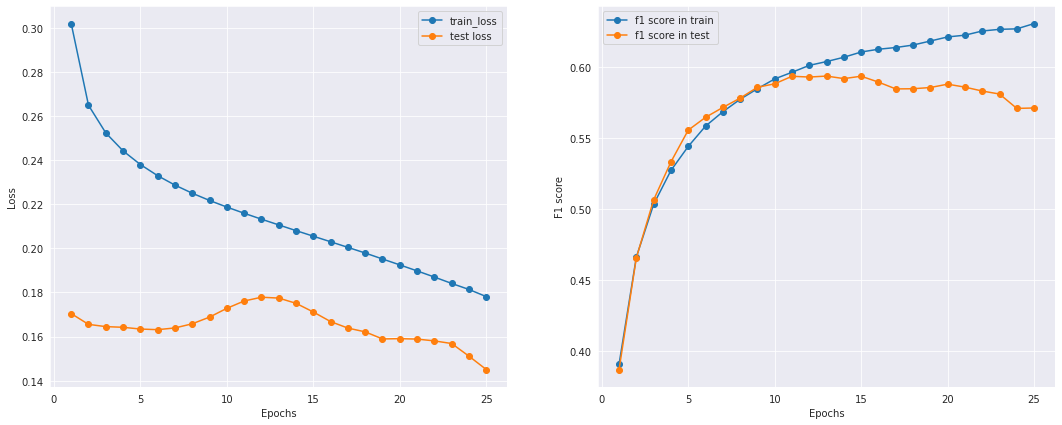

100%|██████████| 25/25 [13:45<00:00, 33.03s/it]


In [74]:
# Deben ir en la misma celda donde se entrena, de lo contrario no fija la semilla
torch.manual_seed(100)

# These will usually be more like 32 or 64 dimensional.
EMBEDDING_DIM = 20
HIDDEN_DIM = 20
EPOCHS = 25

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
model.to(torch.device(dev)) # Lo mueve a la GPU, en caso de que haya
# model.cuda()              # Pasa todo a la GPU, da error si no hay GPU        
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

with torch.no_grad():
    inputs = prepare_sequence(train_data[0][0], word_to_ix)
    tag_scores = model(inputs)
#     print(tag_scores)
 
train_loss = []
test_loss = []
f1_scores_train = []
f1_scores_test = []

for epoch in trange(EPOCHS): 
    train_val = 0.0
    test_val = 0.0
    for sentence, tags in train_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        train_val += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss.append(train_val/len(train_data))
                
    for sentence, tags in test_data:
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)     
        
        tag_scores = model(sentence_in)
        
        loss_test = loss_function(tag_scores, targets)
        test_val += loss_test.item()
        
    test_loss.append(test_val/len(test_data))
    
    f1_scores_train.append(f1_scores(train[['spans', 'text']]))
    f1_scores_test.append(f1_scores(test[['spans', 'text']]))
    
    clear_output(wait=True)
    plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test)
            
# torch.save(model, 'Models/LSTM_20.pt')

En lo anterior, parece que empieza a haber overfitting en eso de la época 15 (ver la gráfica izquierda de F1, esa es la importante para la competencia).

In [77]:
np.max(f1_scores_train), np.max(f1_scores_test)

(0.630362108041687, 0.5933821621545979)

<a name="4"></a>

## Evaluation

In [79]:
evaluation = pd.read_csv('../Datos/tsd_test.csv')
evaluation.head()

text
0  That's right. They are not normal. And I am st...
1  "Watch people die from taking away their healt...
2  tens years ago i contacted the PDR and suggest...
3  The parallels between the ANC and the Sicilian...
4  Intel Community: ‘How can we work for a Presid...

In [81]:
indices_evaluation = []

for text in evaluation['text']:
    tagged_sentence = tagger_LSTM(text)   
    tagged_sentence = [(x[0], tag_to_ix[x[1]]) for x in tagged_sentence]
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_evaluation.append(prediction_index)
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
          color_toxic_words(prediction_index, text)) 

Pred: That's right. They are not normal. And I am starting from the premise that they are ABNORMAL. Proceed wth the typical racist, bigot, sexist rubbish.
Thanks!
Pred: "Watch people die from taking away their healthcare"

DING DING DING!  Winner of stupid post of the day award!
Pred: tens years ago i contacted the PDR and suggested that the time might be good to work with alaska on building a gas line.. alaska rejected them without even consideration despite china being flush with cash and hungry for gas.. and set up another infamous boondoggle.. the transcanada-exxon rip off that we are still paying for and have yet to receive anything of value.. hundreds of millions of dollars on studies.. and buyouts.. i hope china says f you alaska.. you are nothing but ignorant people..
Pred: The parallels between the ANC and the Sicilian Mafia are glaring. The ANC has always been run by a few "families" who treat the state as 'turf' ; as just one big piggy bank for their self-enrichment. The gov

Pred: Far far far more dignity than the current orange face orangutan sitting in the office now.

Why they had their faults as all leader do with some policy, they weren't full blown sexual predators, narcissists,  liars, and they all knew how to apologize when the time came. Just look at the dignity of the current Potus. What a sham. I'd take anyone of his predecessors including W before this moron.
Pred: Never! Rampahosa will be a very useless president.
Pred: Braddah needs to find another line of work. He's too stupid to be a criminal.
Pred: No, dumdum-you dont get it. The business does not get to decide who he serves and who he does not. If he makes cakes for one, he must make them for ALL
Pred: boo hoo hoo. Poor ting. Mayor Caldwell is so hated.   

Nice try dragging Trump into this. Too pathetic.
Pred: Stupid clerk.  I wonder if he has been fired yet.
Pred: You got that right, Stevens; one damn thing after another by the Republicans.  Like cats on a hot tin roof.
Pred: Fuck the p

Pred: I'll ignore your "stupid" insult and reply anyway... 

No, the point isn't to be an average team that has a hot streak somewhere in the season that gives them a record where they barely hang on and steak into the playoffs.  The point is to be a good team PERIOD that can win most of their games not just during a hot streak anomaly, but throughout most of the season and in the playoffs.  You seem to have completely missed that nuance of my comment.  

Of course it's better to make the playoffs than not make the playoffs.  Of course it's better to have a hot streak than not have a hot streak.  But my point was that aside from that early hot streak, they were an average-at-best team for most of the season.  The early hot streak was the anomaly.  The sub-.500 team we saw after that is what they were for most of the season and heading into the playoffs.
Pred: Yeah, that 9/11 thing was the British again, all confident after they got away with bombing Pearl Harbor in 1941. Back to the tr

Pred: So Trump is the lesser of two weevils.  Vote your conscience.
Pred: No it wasn't. It personally attacked Trump as "simply stupid."
Pred: His skill at foreign affairs is off to a very bad start.  Confucius say "he who blabs with big ego get big kick in ass".
Pred: This is stupid, as is any analysis that does not consider foreign investment in real estate.
Pred: "The hypocrite turns Christ's teachings to serve his own purpose."

Yessssss...
Pred: Two days ago I saw a stupid driver driving backwards on a half block.  I couldn't pull my cell phone out fast enough to  take a video.  The driver showed complete disregard to the rules of the road, and there was no way that he could see around the blindspot of his vehicle.  Had there been another vehicle making a right turn down that same half block, the reckless driver would've crashed into the other driver.
Pred: Reminds me of Trudeau's pledge to reform the Canadian voting system, which was the cornerstone of his election promises. Sad 

Pred: And water is still wet you idiot
Pred: CNN just fired her.  They create the environment where this kind of dangerous idiocy can thrive, and then they fire her. What hypocrites!
Pred: Oh no, since Trump is a true elitest - and cares less about the working class, except for what they can do for him - anyone with a brain knew he was going to surround himself with fellow elitest users like himself.  As a narcissistic, egocentric, bullying and strangely personally insecure billionaire who inherited money from daddy and made money by cheating everyone with whom he came into contact, I expected him to do exactly what he did. Only an idiot would think Trump cares about the common working man. Only an idiot would believe anything he says. Only an idiot would vote for him. Only an idiot would support him.
Pred: Man America sucks.  I hope these refugees will seek asylum in a good country like Canada.  We don't deserve them.
Pred: Being stupid with a gun is a privilege, Not a "Right"!
Pred: 

Pred: You're an awfully whiny little snowflake.
Pred: Really?  How old are you?  I have been to Puerto Rico numerous times and even hired people from Puerto Rico.  I am not an expert, but I do recall over the past few years that Puerto Ricans tried to assassinate President Truman, shot up the Congress and wounded a few Congressmen.  I recall those perpetrators being released and having a parade in the Puerto Rican neighborhood of NYC.  I recall them being hailed as heroes when they returned to P.R.  I also remember well that there have been three elections in Puerto Rico.   The people had a choice of becoming a state (This would have required them to pay federal taxes.  They never paid a cent.) or to vote Independence or to leave things as they are (Get all the free stuff and benefits from the U.S. just as if the whole island was on federal welfare.).  And you think we have ignored P.R.  Hell man, they drove out the Navy which provided Billions to their economy and thousands of jobs an

Pred: is hard to build a base when the president being a self centered narcissist who would never compromise in legislation, after over 300 bills always was about his way 100% or nothing! ,, obama was the problem not the tea party people who actually stood for good government without raising anymore taxes pal,.. its you left wingers that are hyper partisan period, and nut job stupid too
Pred: aa the stupidity and bs the left makes up never ends
Pred: yeah he is a moron.  him and krooked kathleen.  see these 2 fools at the airport, handing out winter coats and boots.  such a farce.  they should be ashamed of themselves but instead they are globe trotting and hiding as too afraid of getting lynched.  trudeau is back but hopefully the UN will take him and his selfies
Pred: Well OK, maybe not an idiot ..... but I think we can all agree on A$$HOLE.
Pred: Cruz is a piece of garbage a globalist fraud
Pred: What part of Universal Healthcare do these idiots in Washington not understand. It's ti

Pred: If you've mowed down that many deer and other creatures then may I suggest that driving a truck isn't such a good thing. I've been driving for many a year and have yet to hit one even though I've lived in deer country for extended periods of time. I can usually avoid them but then in a sloth turning vehicle like a F350 I suspect that avoiding things isn't the easiest.  It's either that or you a crappy driver.
Pred: Then they really aren't fans, just melodramatic idiots who want to turn the USA into Nazi Germany.
Pred: Good...one less idiot who has no respect of the law, or driving, or people.
Pred: Damn, that was well written. I went for the obvious or as Helgard put it, the carcature. Your way is so much better.
Pred: Climate change is a hoax, and the earth is flat. Trump is an idiot.
Pred: Its all these liberal fools moving here it never used to be bad 😀
Pred: Follow the money Alaskans...Chris Christie has already been proven to be a liar and a crook over injuries and taxpayer 

Pred: Trump may be an ass at times,  but there can't be that many stupid people out there!  Just don't trust this poll!
Pred: What a load of crap. Everyone who is
willing to speak the truth about the
cowardly left is now apparently some
kind of sex fiend. But the pervert Bill
Clinton is okay. Oh, my bad the coward
supports the cowardly left.
Pred: That stupid social worker...Sundin...her mother will die and only then will she realize what real loss is.

What a bunch of stupid people, destroying family over something like this.
Pred: Well, you know Harold, you can't fix STUPID!
Pred: His Secretary of State has called him a moron.  Mental Health experts have looked at his behavior and agreed that he is a narcissistic egotist unqualified to be POTUS. Even many Republicans agree with that.
Trump contradicts himself from day to day about important policy matters. He is a reality show star,  skilled at fooling a certain segment of the public into thinking he is a great man, and playing on th

Pred: It's a pity that some, such as yourself, are so ignorant as to the source of rights, let alone the constitution or existing gun laws, that you would make such an idiotic statement. Being governed by your own emotions is not a virtuous quality.
Pred: ok then you dont use gasoline, plastic  or such anything else right??? ya hypocrite bs stupidity as usual
Pred: United is garbage.
Pred: Considering Trump's confrontational style and inflammatory rhetoric, the DMZ visit seems like a particularly stupid idea.  Find some other way to show support for our troops there, without adding to their risk
Pred: Christy has no authority over the port. That is federal jurisdiction. She's a fool, just like Trump.
Pred: Trump is unfit to be President.
His ignorance embarrasses Amerca.
Pred: As the saying goes, you can't fix stupid, especially when it's bolstered by denial.
Pred: This judge IS an idiot. 
His ruling directly contradicts the clear language empowering the President to issue whatever imm

Pred: nice try attempting to lable the right wing as the problem when we have seen LIBREALS like in ontairo and federally abuse our system for money over and over and over... your attempt is typical of the alt left,  being stupid and full of bs
Pred: How often can we say Trump is a fool and incompetent?
Pred: I would not doubt that by the time the Rail is completed(whenever that is) there will be a few more chiefs being hired. When they fine out who they are really working with a resignation will be turned in. Don't know about you guys but working with idiots is very hard to do.
Pred: Big conflict of interest....he does not represent the tax paying public...what a stupid article.
Pred: No Rationalthought, Bigfire45 understood completely.  It started as all about nuclear war.  When those political activists posing as scientists were outflanked by the collapse of the USSR, they couldn't just give up what was a stupid symbol in the first place.  Oh no, the "doomsday clock" was deeply mean

Pred: Nice going, Trudeau. Now your $10 million payout will actually cost billions more in legal fees.

Someone please get rid of this idiot.
Pred: breathtakingly stupid comment
Pred: It seems the Saudi ambassador has been taking diplomacy lessons from Donald Trump.  Is that the best they can do in the way of a representative?  Pathetic.
Pred: Only way to fix the economy and the country is to impeach Trudeau and his cabinet of clowns.
Pred: Yes...Yes they do "need to die"....No and's, if's or but's about it, and especially the whine heard so loudly from the Anchorage crowd of a few years ago....the "they were here first" crap...
Pred: Why doesn't he just give up this primeministership and do what he is fitted for ... become another useless UN Ambassador, travelling the world at other people's expense and making stupid pontifical comments.
Pred: America: How does it feel to be the most ridiculous country in the world? Do you now feel that Trump is making America great again?  I think it

Pred: 1. You're an idiot. I said nothing about medical care, and I wasn't talking about hunter/gatherers. It is a FACT that the first plastered walls were built by the SAME early farmers who also built the first grain stores. Agriculture allowed, for the first time, overproduction of food - so working for a few months a year would provide food for the rest of the year. Plaster was a major thing - it has ZERO survival value. It takes days of backbreaking labour, maintaining a fire at very high heat constantly - for no reward other than aesthetics. It's something that would never have happened in a society without an abundance of leisure time. And it's important that it did - the same fire-handling techniques they developed to make their walls smooth - was what allowed their grandchildren to smelt ore and end the stone age.
2. Yawn. I would have cared if it was related to the topic. Still a strawman.
3. That scenario you paint was never very real.
Pred: The malignant narcissist, mentally

Pred: What all this stupid DemonRat possessed Trump play is demonstrating is a new in-controversial fact that incoming Presidents of different Parties must and I repeat must remove all previous Party hacks from all positions of power, a complete PURGE, from the WH, to the NSA to the Courts and all Departments like the GAO, EPA etc!
Pred: I have no words .... except "hypocrite"!!
Pred: what are you smoking? no one has uses it in decades pal, its been ripped out of buildings in renos for decades, this is not harpers fault , of pehaps you can add CHRETIEN in that mix since that LIBERAL didnt ban it either ! that claim is typical bias stupidity. ,, as for your thanks for liberals, take your paid trolling trash elsewhere, you are what canada doesnt need a shill of stupidity.
Pred: We all will die.  That is guaranteed.  

The 'death we deserve'?  Opinion only, and  subject to your personal biases, beliefs and prejudices.

A three-year old infant does not "deserve to die" or "die the death th

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Pred: As Trump's EPA is scrubbing EPA website of any climate change/global warming messages they are also removing EPA Museum exhibits that opened this January.  This anti-science uneducated President & his trumpers are beyond ignorant... they are dangerous.  Enjoy this heat because it's the new norm.
Pred: Liberal sucks.Step down Lib.
Pred: You're right...saying she's stupid is roughly comparable to saying that the sun rises in the east
Pred: She will win this and rightfully so.  Sue some sense into the sadistic, incompetent idiots running our jails.
Pred: A side note from an ex furniture mover who drank 5 gallons of water a day, and sweated most of that out.  Ban is the deodorant you are looking for. Right guard is a joke, that works until, maybe 8:30 AM.  Whisky? is that really that organic? Capitalist pigs!
Pred: When these idiot Dems/Progressives get tired of the Trump=-Russia investigation maybe they can have a special prosecutor named to investigate the monster that is NOT under

In [82]:
evaluation['spans'] = indices_evaluation
evaluation = evaluation[['spans', 'text']]
evaluation.head()

spans  \
0  [133, 134, 135, 136, 137, 138, 139, 140, 141, ...   
1                           [81, 82, 83, 84, 85, 86]   
2           [483, 484, 485, 486, 487, 488, 489, 490]   
3           [413, 414, 415, 416, 417, 418, 419, 420]   
4  [17, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 1...   

                                                text  
0  That's right. They are not normal. And I am st...  
1  "Watch people die from taking away their healt...  
2  tens years ago i contacted the PDR and suggest...  
3  The parallels between the ANC and the Sicilian...  
4  Intel Community: ‘How can we work for a Presid...

Para la evaluación se debe subir un zip con un archivo txt de la siguiente manera (al final subir el archivo `spans-pred.zip` que se produce):

In [83]:
predictions = evaluation['spans'].tolist()
ids = evaluation.index.tolist()

In [86]:
with open("spans-pred.txt", "w") as out:
    for uid, text_scores in zip(ids, predictions):
        out.write(f"{str(uid)}\t{str(text_scores)}\n")
        
# Zip the predictions
! zip -r spans-pred.zip ./spans-pred.* 
! rm spans-pred.txt
! mv spans-pred.zip ../spans-pred.zip

updating: spans-pred.txt (deflated 84%)
